# Prototype solver example

*I love convex optimization.  You tell "qp" to minimize a (non-negative definite) quadratic form over a polyhedron of fiesable points and it does it every time.*  

## Practice for implementing a BFGS method with CVXOPT 
This notebook implements a BFGS method using the CVXOPT package with their quadratic program solver.  

The QP problem is specified as follows: 
\begin{align}
\mathrm{minimize}\;&\; \frac{1}{2} x^{T} P x + q^{T} x\\
\mathrm{subject\; to}\;&\; G x \leq h\\
\;&\; A x = b
\end{align}

The implementation of BFGS here is based on setting up a QP to solve sub-problem of finding a step that will decrease the value of a non-linear cost function (here the rosenbrock function).  The Taylor approximation is written as follows: 
\begin{align}
f(x + s) \approx f(x) + \nabla f(x)^{T}\, s + \frac{1}{2} s^{T} \,\nabla\nabla f(x)\, s 
\end{align}

To use the Taylor approxiamtion formula I need the gradient and hessian.  The gradient can be computed, but the hessian is too expensive.  Insead BFGS uses an approximate hessian derived from previous calculations of the step, s, and the gradient, $\nabla f(x)$. 

### Approximating the Hessian

In this method I start with assuming that the Hessian is the identity matrix scaled by a large factor $\gamma=1000$.  This factor puts restrictions on the size of the initial steps.  
\begin{align}
H_{0} = \gamma I
\end{align}

Assuming we have the first step, s_{0}, already the Hessian will be updated as follows. 
\begin{align}
y0 &= \nabla f(x_{0} + s_{0}) - \nabla f(x_{0})\\
h_{01} &= \frac{H_{0} s_{0}}{\sqrt{s_{0}^{T}H_{0}s_{0}}}\\
h_{02} &= \frac{y_{0}}{\sqrt{y_{0}^{T} s_{0}}}\\
H_{1} &= H_{0} - h_{01}^{T}\,h_{01} + h_{02}^{T}\,h_{02}
\end{align}
One nessesary condition is positivity of the dot product $y^{T}s>0$.  Without this condition we cannot gaurentee that the resulting matrix will be positive definite. 

### Setting up the QP for the subproblem

Using the above rule we are gauranteed to generate a positive definite $H$, which we can substitute into Taylor's formula.  This gives us a quadratic form to minimize. 
\begin{align}
\Psi_{k}(s) = \nabla f(x_{k})^{T} s_{k} + \frac{1}{2} s_{k}^{T}H_{k}s_{k}.  
\end{align}
Comparing this formula with the notation used by the cvxopt solver, we can see that the matrix $P=H_{k}$ and the vector, $q = \nabla f(x_{k})$.  I add positivity constraints on the updated parameter, $x_{k+1} = x_{k} + s_{k}$, through the inequality constraints with $G=-I$ and $h=x_{k}$. 

### Memory effeciency: avoid keeping a dense $N \times N$ hessian

The proceedure assembles the approximate Hessian matrix, which is a dense matrix.  A better option would be to represent H in some sparse way.  I think this can be done by storing the vectors $h_{k1}$ and $h_{k2}$.  I'll need to add unknowns to the problem.  



$z_{k, 1}=$using the equality constraints. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
from scipy.optimize import minimize, rosen, rosen_der

from cvxopt import blas, lapack, matrix, solvers 
solvers.options['show_progress'] = False

EPS = sp.finfo(float).eps
print("machine epsilon: {0}".format(EPS))

machine epsilon: 2.22044604925e-16


In [2]:

x0 = np.array([1.5, 1.5])#, 0.8, 1.9, 1.2])
y0 = rosen(x0)
dy0 = rosen_der(x0)


res = minimize(rosen, x0, method='nelder-mead',
               options={'xtol': 1e-8, 'disp': True})
print(res.keys())
print('\nfun = {0}'.format(res['fun']))
print('\nxmin = {0}'.format(res['x']))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 84
         Function evaluations: 159
['status', 'success', 'final_simplex', 'nfev', 'fun', 'x', 'message', 'nit']

fun = 5.84098143133e-18

xmin = [ 1.  1.]


In [3]:
def my_descent(x0, max_steps=100, alpha=.0001, f=rosen, df=rosen_der):
    "Steepest decent algorithm. "
    alpha = .0001

    #define old parameters
    xnew = x0
    fnew = f(x0)
    dfnew = df(x0)
    
    xvec = sp.zeros((max_steps+1, x0.size))
    xvec[0] = x0
    for i in range(max_steps):
        xold = xnew
        fold = fnew
        dfold = dfnew
        
        xnew = xold - alpha * dfold
        fnew = f(xnew)
        dfnew = df(xnew)
        
        # Store the steps
        xvec[i+1] = xold
        
    return xvec
    
def my_qp(P, q, G, h, full_output=False):
    "Interface to cvxopt.solvers.qp with python."
    _P = matrix(P)
    _q = matrix(q)
    _G = matrix(G)
    _h = matrix(h)
    sol = solvers.qp(_P, _q, _G, _h, abserr=1e-9)
    out_x = (sol['x'])
    if full_output:
        return sol
    else:
        return sp.array(out_x).reshape(-1)
    
def update_hessian(H, s, y):
    "Return an updated hessian approximation"
    R1 = sp.outer(sp.dot(H, s), sp.dot(s, H)) / sp.dot(s, sp.dot(H, s))
    R2 = sp.outer(y, y) / sp.dot(y, s)
    return H - R1 + R2

    
def my_bfgs(x0, f=rosen, df=rosen_der, max_steps=20, gamma=1000, abstol=1e-9):
    "My coding of a BFGS method."
    
    # Define the starting quadratic problem
    P0 = gamma * sp.eye(x0.size)
    q0 = df(x0)
    G = -sp.eye(x0.size)
    h0 = x0    
    s0 = my_qp(P0, q0, G, h0)
    x1 = x0 + s0
    q1 = df(x1)
    y0 = q1-q0
    P1 = update_hessian(P0, s0, y0)
    
    # Loop for several more local problems
    xvec = sp.zeros((max_steps+2, x0.size))
    xvec[(0, 1), :] = x0, x1
    for i in range(max_steps):
        x = x1
        P = P1 
        q = q1
        h = x1
        s = my_qp(P, q, G, h)
        x1 = x + s
        q1 = df(x1)
        y = q1 - q
        
        P1 = update_hessian(P, s, y)
        xvec[i+2] = x1
        
        diff = f(x1) - f(x)
        if abs(diff) <= abstol:
            xvec[i+3:] = x1
            break
    
    return xvec
    


## Solve the problem
xvec_descent = my_descent(x0, max_steps=30)
xvec_bfgs = my_bfgs(x0, max_steps=30)

xtrue_descent = sp.ones_like(xvec_descent)
xtrue_bfgs = sp.ones_like(xvec_bfgs)

err_descent = abs(xvec_descent - xtrue_descent).sum(1)
err_bfgs = abs(xvec_bfgs - xtrue_bfgs).sum(1)





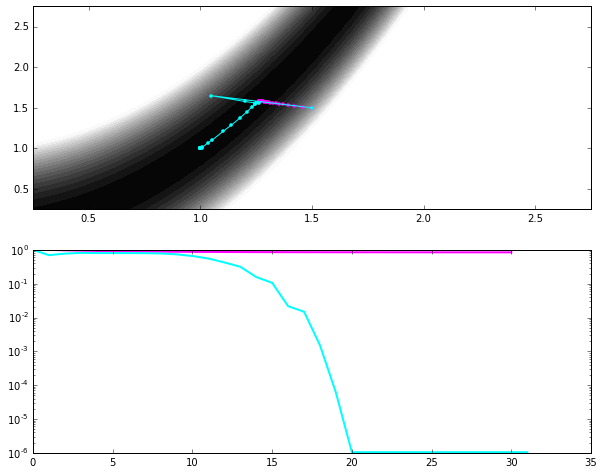

In [4]:
x = sp.linspace(.25, 2.75)
y = sp.linspace(.25, 2.75)
xx, yy = sp.meshgrid(x, y, indexing='ij')
vals = rosen(sp.array([xx, yy]))
levels = sp.linspace(0, 100, 20)

fig = plt.figure(0, (10, 8))
ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

ax0.contourf(xx, yy, vals, levels, cmap='gray')
ax0.plot(xvec_descent[:,0], xvec_descent[:,1], c='magenta', marker='.')
ax0.plot(xvec_bfgs[::1,0], xvec_bfgs[::1,1], c='cyan', marker='.')

ax1.semilogy(err_descent, color='magenta', linewidth=2.0)
ax1.semilogy(err_bfgs, color='cyan', linewidth=2.0)


In [5]:
xvec_bfgs


array([[ 1.5       ,  1.5       ],
       [ 1.049     ,  1.65      ],
       [ 1.19850289,  1.57858801],
       [ 1.26101722,  1.55419904],
       [ 1.24746259,  1.55898915],
       [ 1.24807025,  1.55857445],
       [ 1.24803448,  1.55837042],
       [ 1.24650814,  1.55301072],
       [ 1.2427846 ,  1.54210775],
       [ 1.23055831,  1.50893367],
       [ 1.20795902,  1.4507143 ],
       [ 1.17823857,  1.378107  ],
       [ 1.13857477,  1.28749137],
       [ 1.10313263,  1.21443982],
       [ 1.05323347,  1.10437811],
       [ 1.03517106,  1.07090524],
       [ 1.00775196,  1.01394239],
       [ 1.00496449,  1.00990463],
       [ 1.00051404,  1.00099182],
       [ 1.0000206 ,  1.00003918],
       [ 1.00000034,  1.0000007 ],
       [ 1.00000034,  1.0000007 ],
       [ 1.00000034,  1.0000007 ],
       [ 1.00000034,  1.0000007 ],
       [ 1.00000034,  1.0000007 ],
       [ 1.00000034,  1.0000007 ],
       [ 1.00000034,  1.0000007 ],
       [ 1.00000034,  1.0000007 ],
       [ 1.00000034,

In [6]:
## Try it out on a large problem
nx = 1000
x0 = .75 + .5 * sp.rand(nx)

xvec_bfgs = my_bfgs(x0, gamma=1000, max_steps=50)
xvec_descent = my_descent(x0, alpha=1.0/1000, max_steps=50)
xtrue = sp.ones(nx)

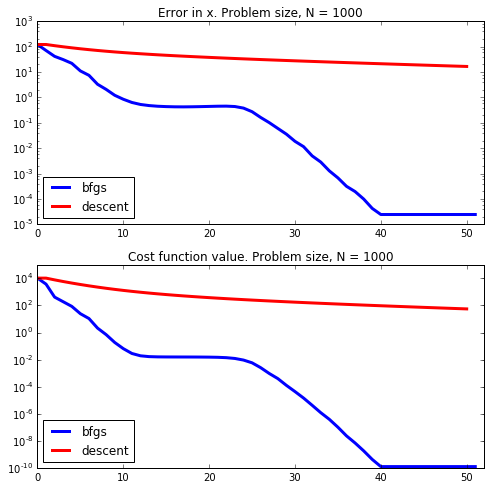

In [7]:
err_bfgs = abs(xvec_bfgs - xtrue).sum(1)
err_descent = abs(xvec_descent - xtrue).sum(1)
fvals_bfgs = sp.array([rosen(_x) for _x in xvec_bfgs])
fvals_descent = sp.array([rosen(_x) for _x in xvec_descent])


fig = plt.figure(0, (8, 8))
ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

ax0.semilogy(err_bfgs, '-b', linewidth=3, label='bfgs')
ax0.semilogy(err_descent, '-r', linewidth=3, label='descent')
ax0.set_title('Error in x. Problem size, N = {0}'.format(nx))
ax0.legend(loc='best')
ax0.set_xbound(0, xvec_bfgs.shape[0])

ax1.semilogy(fvals_bfgs, '-b', linewidth=3, label='bfgs')
ax1.semilogy(fvals_descent, '-r', linewidth=3, label='descent')
ax1.set_title('Cost function value. Problem size, N = {0}'.format(nx))
ax1.legend(loc='best')
ax1.set_xbound(0, xvec_bfgs.shape[0])

